## Chest X-Ray pneumonia detection

### change log
1. ResNet152 

### Import library
Here we import necessary libraries

In [67]:
import keras
import numpy as np

#from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import glob
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import os
%matplotlib inline

### Access the image files
We use the chest X ray images as the input.

In [68]:
test_path = './data/chest_xray/test/'
train_path = './data/chest_xray/train/'
label_normal = 'NORMAL/'
label_pneumonia = 'PNEUMONIA/'

### Read and explore the image files

In [69]:
suffix = '*.jpeg'
normal_train_path = train_path + label_normal + suffix
pneumonia_train_path = train_path + label_pneumonia + suffix
normal_test_path = test_path + label_normal + suffix
pneumonia_test_path = test_path + label_pneumonia + suffix
normal_train_name_list = glob.glob(normal_train_path)
pneumonia_train_name_list = glob.glob(pneumonia_train_path)
normal_test_name_list = glob.glob(normal_test_path)
pneumonia_test_name_list = glob.glob(pneumonia_test_path)

In [70]:
# Generate image array

def get_image_array(name_list):
    img_array = []
    for name in name_list:
        img = plt.imread(name)
        img_array.append(img)
    return np.array(img_array, dtype='object')

In [71]:
normal_train_img = get_image_array(normal_train_name_list)
normal_test_img = get_image_array(normal_test_name_list)
pneumonia_train_img = get_image_array(pneumonia_train_name_list)
pneumonia_test_img = get_image_array(pneumonia_test_name_list)

In [72]:
print('The normal train image size is {}'.format(normal_train_img.shape[0]))
print('The pneumonia train image size is {}'.format(pneumonia_train_img.shape[0]))
print('The normal test image size is {}'.format(normal_test_img.shape[0]))
print('The pneumonia test image size is {}'.format(pneumonia_test_img.shape[0]))

The normal train image size is 922
The pneumonia train image size is 2740
The normal test image size is 206
The pneumonia test image size is 390


### Prepare the image data
First of all we prepare the validation set in addition to train set and test set.

In [73]:
# # Create validation set
# # Concat 2 train arrays as a whole train set
# arr1 = normal_train_name_list.copy()
# arr2 = pneumonia_train_name_list.copy()
# # The complete train set
# arr1.extend(arr2)
# print('The train set contains {} chest X_Ray images'.format(len(arr1)))

# # Spin out validation set from the train set
# # 30%
# train_image_set, validation_image_set = train_test_split(arr1, test_size=0.3, shuffle=True, random_state=42)
# print('The new train set contains {} chest X_Ray images'.format(len(train_image_set)))
# print('The new validation set contains {} chest X_Ray images'.format(len(validation_image_set)))

# # print(validation_image_set)

# # Need to move validation set to validation folder
# # Cut and paste
# print('./data/chest_xray/train/NORMAL\\NORMAL-263932-0001.jpeg'.replace('train', 'validate'))

In [74]:
validate_path = './data/chest_xray/validate/'
test_path = './data/chest_xray/test/'

In [75]:
# for source in validation_image_set:
#     dest = source.replace('train', 'validate')
#     os.rename(source, dest)

normal_validate_path = validate_path + label_normal + suffix
pneumonia_validate_path = validate_path + label_pneumonia + suffix
normal_validate_name_list = glob.glob(normal_validate_path)
pneumonia_validate_name_list = glob.glob(pneumonia_validate_path)
normal_validate_img = get_image_array(normal_validate_name_list)
pneumonia_validate_img = get_image_array(pneumonia_validate_name_list)
print('The normal validate image size is {}'.format(normal_validate_img.shape[0]))
print('The pneumonia validate image size is {}'.format(pneumonia_validate_img.shape[0]))

The normal validate image size is 427
The pneumonia validate image size is 1143


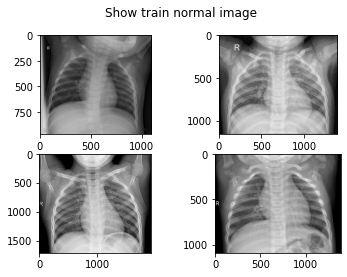

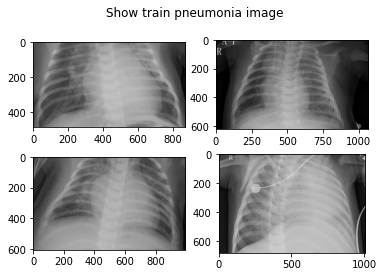

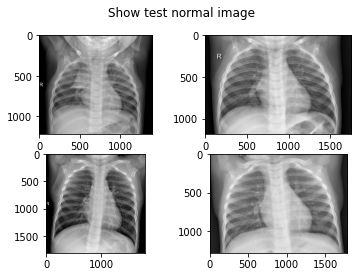

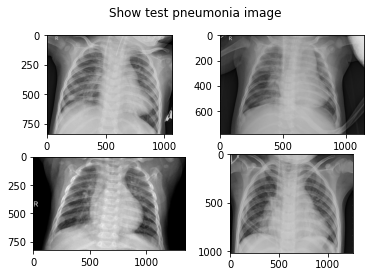

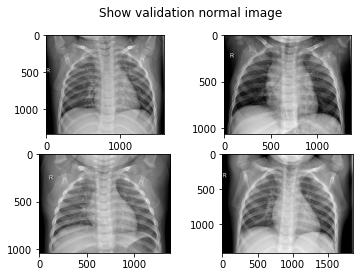

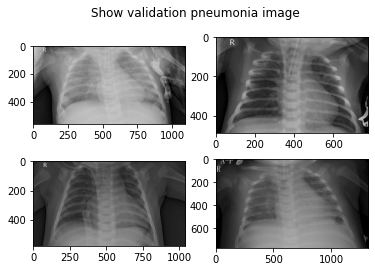

In [76]:
def show_sample_image(image_array, title):
    plt.figure()
    plt.suptitle(title)
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(image_array[random.randrange(200)], cmap='gray')

show_sample_image(normal_train_img, 'Show train normal image')
show_sample_image(pneumonia_train_img, 'Show train pneumonia image')

show_sample_image(normal_test_img, 'Show test normal image')
show_sample_image(pneumonia_test_img, 'Show test pneumonia image')

show_sample_image(normal_validate_img, 'Show validation normal image')
show_sample_image(pneumonia_validate_img, 'Show validation pneumonia image')

### Refactor the image files
Here we use Tensorflow ImageDataGenerator to refactor and resize the image files.
train_path; test_path; validate_path

In [77]:
# ImageDataGenerator for train set
# Image augmentation on train set.
IMAGE_SIZE = 50
BATCH = 32
train_img_datagen = ImageDataGenerator(rescale=1./IMAGE_SIZE,
                                       zoom_range = 0.1, #zoom in and out between 0.9(+) and 1.1(-)
                                       width_shift_range = 0.1,
                                       height_shift_range = 0.1,
#                                        horizontal_flip=True, #randome flip the image horizontally.
#                                        rotation_range=90,   #randome rotate the image between 0 and 90 degree.
#                                        brightness_range=[0.8,1.5], #randome adjust brightness: >1 is brighter.
                                      )
# Load and refactor the train set images
train_source = train_img_datagen.flow_from_directory(train_path,
                                             #directory=train_path, #dataframe contains the full paths
                                                     target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                     class_mode = 'binary',
                                                     batch_size = BATCH,
                                                     shuffle=False,
                                                     seed = 42)

# ImageDataGenerator for validation set
valid_img_datagen = ImageDataGenerator(rescale=1./IMAGE_SIZE)
# Load and refactor the validation set images
validation_source = valid_img_datagen.flow_from_directory(validate_path,
                                                          target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                          class_mode = 'binary',
                                                          batch_size = BATCH,
                                                          shuffle=False,
                                                          seed = 42)

# ImageDataGenerator for test set
test_img_datagen = ImageDataGenerator(rescale=1./IMAGE_SIZE)
# Load and refactor the test set images
test_source = test_img_datagen.flow_from_directory(test_path,
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   class_mode = 'binary',
                                                   batch_size = BATCH,
                                                   shuffle=False,
                                                   seed = 42)
print(train_source)
print('train image shape is {}'.format(train_source.image_shape))
print(validation_source)
print('validation image shape is {}'.format(validation_source.image_shape))
print(test_source)
print('test image shape is {}'.format(test_source.image_shape))

Found 3662 images belonging to 2 classes.
Found 1570 images belonging to 2 classes.
Found 596 images belonging to 2 classes.
train image shape is (50, 50, 3)
validation image shape is (50, 50, 3)
test image shape is (50, 50, 3)


### Prepare the model
Here we prepare the CNN model.

In [78]:
# # CNN using Keras' Sequential capabilities
# FILTERS = 32

# model = Sequential()

# ## 5x5 convolution with 1x1 stride and 32 filters
# model.add(Conv2D(FILTERS, (10,10), strides = (2,2), padding='same',
#                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Activation('relu'))

# ## Another 5x5 convolution with 1x1 stride and 32 filters
# model.add(Conv2D(FILTERS, (10,10), strides = (2,2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Activation('relu'))

# ## The 3rd 5x5 convolution with 1x1 stride and 32 filters
# model.add(Conv2D(FILTERS, (10,10), strides = (2,2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Activation('relu'))

# ## 2x2 max pooling reduces to 3 x 3 x 32
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# ## Flatten turns 3x3x32 into 288x1
# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# # model.add(Dense(2))
# # model.add(Activation('softmax'))

# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# # model.compile(loss='binary_crossentropy',optimizer = Adam(learning_rate=0.00003), metrics='binary_accuracy')
# model.compile(loss='binary_crossentropy',optimizer = Adam(learning_rate=0.0003), metrics='binary_accuracy')

# model.summary()

In [79]:
# ResNet model
from tensorflow.keras.applications import resnet_v2

model = resnet_v2.ResNet50V2(weights='imagenet',
                              input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                              include_top=False)

model.trainable = True
#Input shape = [width, height, color channels]
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = model(inputs)
# Head: keep the same as we did previously.
x = layers.GlobalAveragePooling2D()(x)
# x = layers.MaxPool2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)

#Final Layer (Output)
output = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs=[inputs], outputs=output)

model.compile(loss='binary_crossentropy',optimizer = Adam(learning_rate=0.002), metrics='binary_accuracy')
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2, 2, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 23,696,001
Trainable params: 23,650,561
Non-trainable params: 45,440
__________________________________________

In [80]:
for layer in model.layers[0:5]:
    print(layer)
    layer.trainable = False

model.compile(loss='binary_crossentropy',optimizer = Adam(learning_rate=0.002), metrics='binary_accuracy')
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2, 2, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 23,696,001
Trainable params: 65
Non-trainable params: 23,695,936
______________________________________________

### Fit the model

In [81]:
# Fit the model
history = model.fit(train_source,
                    epochs = 40,
                    validation_data=validation_source,
                    steps_per_epoch=(len(train_source.filenames)/32),
                    validation_steps=(len(validation_source.filenames)/32))

Epoch 1/40
114/114 [==============================] - 87s 745ms/step - loss: 1.2804 - binary_accuracy: 0.6496 - val_loss: 0.5740 - val_binary_accuracy: 0.7274
Epoch 2/40
114/114 [==============================] - 83s 721ms/step - loss: 1.0643 - binary_accuracy: 0.6540 - val_loss: 0.5049 - val_binary_accuracy: 0.7484
Epoch 3/40
114/114 [==============================] - 78s 679ms/step - loss: 0.8169 - binary_accuracy: 0.6857 - val_loss: 0.5148 - val_binary_accuracy: 0.7510
Epoch 4/40
114/114 [==============================] - 76s 666ms/step - loss: 0.6957 - binary_accuracy: 0.7097 - val_loss: 0.4599 - val_binary_accuracy: 0.7529
Epoch 5/40
114/114 [==============================] - 81s 706ms/step - loss: 0.6025 - binary_accuracy: 0.7297 - val_loss: 0.4354 - val_binary_accuracy: 0.7713
Epoch 6/40
114/114 [==============================] - 79s 692ms/step - loss: 0.5303 - binary_accuracy: 0.7510 - val_loss: 0.5467 - val_binary_accuracy: 0.7395
Epoch 7/40
114/114 [==========================

In [82]:
# Evaluate the validation set scores.
score = model.evaluate(validation_source, steps = len(validation_source.filenames)/32, verbose = 0)
print('Val loss of validation set: {}'.format(score[0]),)
print('Val accuracy of validation set: {}'.format(score[1]))

Val loss of validation set: 0.4209260642528534
Val accuracy of validation set: 0.8216560482978821


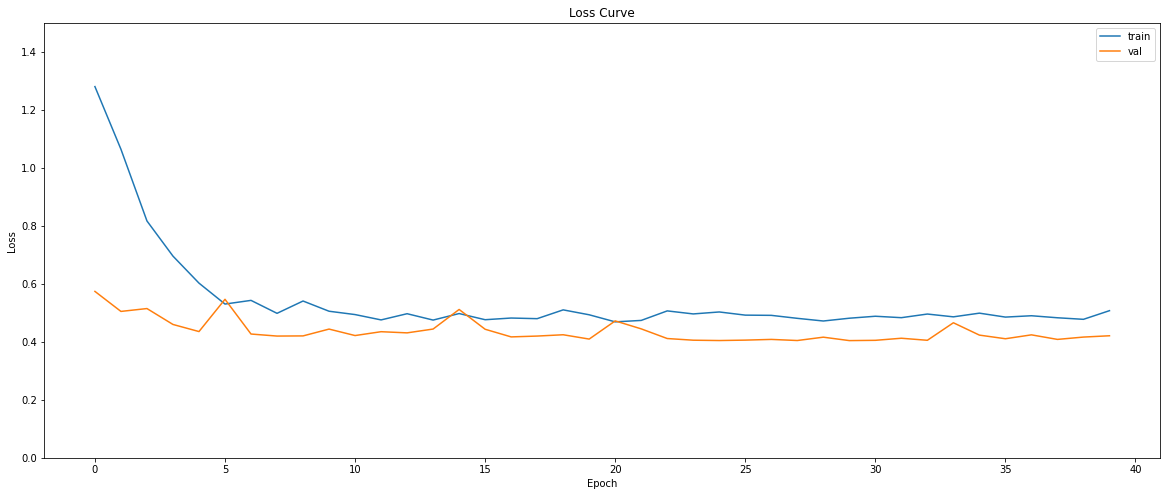

In [83]:
fig, ax = plt.subplots(figsize=(20,8))

plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])

ax.set_title('Loss Curve')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

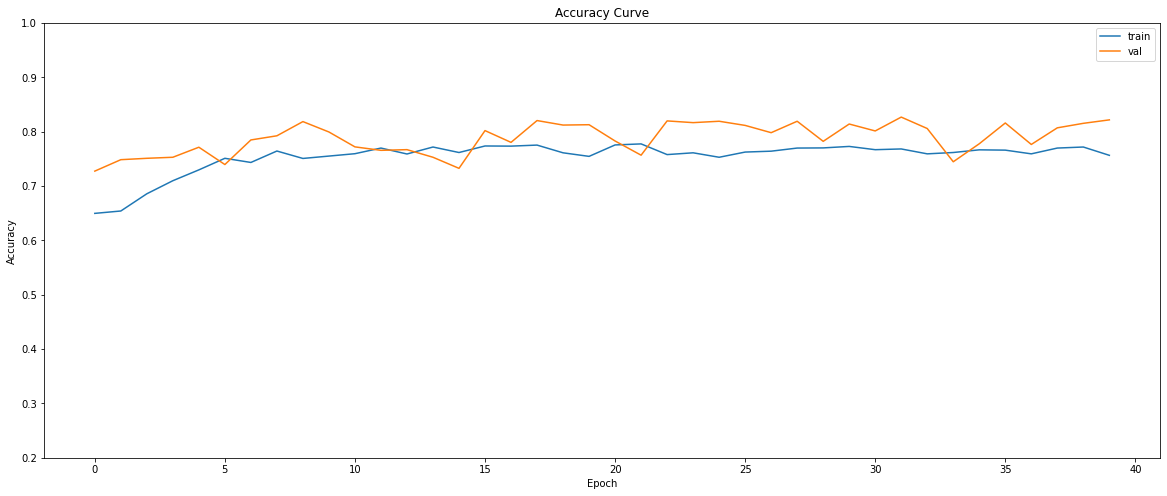

In [84]:
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(history.epoch, history.history['binary_accuracy'])
plt.plot(history.epoch, history.history['val_binary_accuracy'])
ax.set_title('Accuracy Curve')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.20, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [85]:
# Evaluate the test set scores.
score = model.evaluate(test_source, steps = len(test_source.filenames)/32, verbose = 0)
print('Val loss of test set: {}'.format(score[0]),)
print('Val accuracy of test set: {}'.format(score[1]))

Val loss of test set: 0.46439751982688904
Val accuracy of test set: 0.7785235047340393


In [86]:
# Save the model
model.save('./data/pneumonia_model_copy6_Res.h5')
print('model saved...')

C:\Users\mikee\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


model saved...


### Predict

In [87]:
# Predict each of the test images.
prediction = model.predict(test_source, verbose=0)
# The true label values are between -1 and 1 due to sigmoid activation.
# Therefore by default we define label value > 0.5 as the possible penumonia image.
prediction_labels= np.where(prediction > 0.5, 1, 0)

### Evaluate the prediction

In [88]:
# Score the accuracy
true_labels = np.arange(len(test_source.filenames))
for idx, name in enumerate(test_source.filenames):
    if(name.find('NORMAL')!=-1):
        true_labels[idx] = 0
    else:
        true_labels[idx] = 1

0.7785234899328859


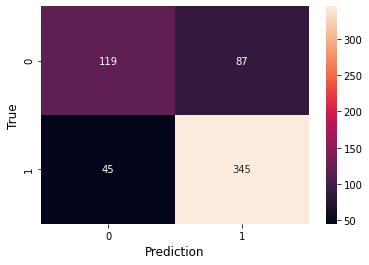

In [89]:
print(accuracy_score(true_labels, prediction_labels))
confusion_matrix = confusion_matrix(true_labels, prediction_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.xlabel("Prediction", fontsize= 12)
plt.ylabel("True", fontsize= 12)
plt.show()

In [90]:
print('                 ====The classification report====')
print(classification_report(true_labels, prediction_labels, labels = [0, 1]))

                 ====The classification report====
              precision    recall  f1-score   support

           0       0.73      0.58      0.64       206
           1       0.80      0.88      0.84       390

    accuracy                           0.78       596
   macro avg       0.76      0.73      0.74       596
weighted avg       0.77      0.78      0.77       596

